In [33]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load args
with open("../args.json", "r") as f:
    args = json.load(f)

In [3]:
# load similarity graph
path_graph = f'{args["results"]}graph/graph_{args["slice_type"]}.json'
with open(path_graph, "r") as f:
    graph = json.load(f)

In [21]:
# get all distances from dict
distances = []
slices = graph.keys()
for slice in slices:
    I = graph[slice].keys()
    for i in I:
        topic_distances = graph[slice][i].values()
        for dist in topic_distances:
            distances.append(dist)
distances = pd.Series(distances)

In [71]:
len(distances)

1719

In [67]:
cum_dist = []
cum = 0
sorted_distances = distances.sort_values(ascending=True)
for elem in sorted_distances:
    cum+=elem
    cum_dist.append(cum)
cum_dist = pd.Series([elem/cum_dist[-1] for elem in cum_dist])

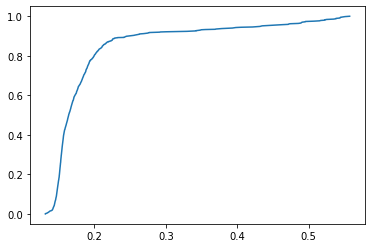

In [68]:
plt.plot(distances_sorted, cum_dist)

In [69]:
distances.describe()

count    1719.000000
mean        0.175590
std         0.055493
min         0.131223
25%         0.151192
50%         0.158587
75%         0.181265
max         0.557220
dtype: float64

In [70]:
distances.quantile(q=[0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])

0.50    0.158587
0.60    0.165697
0.70    0.174885
0.80    0.187775
0.90    0.206157
0.95    0.241383
0.99    0.490850
dtype: float64

 - [ ] cdf
 - [ ] find threshold
 - [ ] plot timeline